In [ ]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install -q "transformers>=4.22.0"
!pip install transformers[torch]
!pip install datasets sentencepiece tensorboard
!pip install datasets

!pip uninstall transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install huggingface_hub

!sudo apt-get install git-lfs --yes

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-nsxk9baa
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-nsxk9baa
  Resolved https://github.com/huggingface/transformers.git to commit 1982dd3b15867c46e1c20645901b0de469fd935f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7522589 sha256=9eebafc8e7d843abdf220b2c47e9b0c760640039028cb61728267153bd3921d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-frzqz23e/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%bash
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
cp -r ICDAR-2019-SROIE/data ./
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [ ]:
import os
import json
from pathlib import Path
import shutil
import tensorflow
from datasets import load_dataset

In [ ]:
base_path = Path('data')
metadata_path = base_path.joinpath('key')
image_path = base_path.joinpath('img')

dic = []

for file_path in metadata_path.glob('*.json'):
  with open(file_path, 'r') as op:
    data = json.load(op)
    text = json.dumps(data)
    if image_path.joinpath(f'{file_path.stem}.jpg').is_file():
      dic.append({"text":text,'file_name':f'{file_path.stem}.jpg'})

with open(image_path.joinpath('metadata.jsonl'), 'w') as f:
  for each in dic:
    json.dump(each, f)
    f.write('\n')

shutil.rmtree(metadata_path)

In [ ]:
from pathlib import Path
import os
import shutil
# from datasets import load_data

base_path = Path('data')
metadata_path = base_path.joinpath('key')
image_path = base_path.joinpath('img')

dataset = load_dataset('imagefolder', data_dir=image_path, split = 'train')
print(f"Number of training samples: {len(dataset)}\nAnd the dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Number of training samples: 626
And the dataset features are: dict_keys(['image', 'text'])


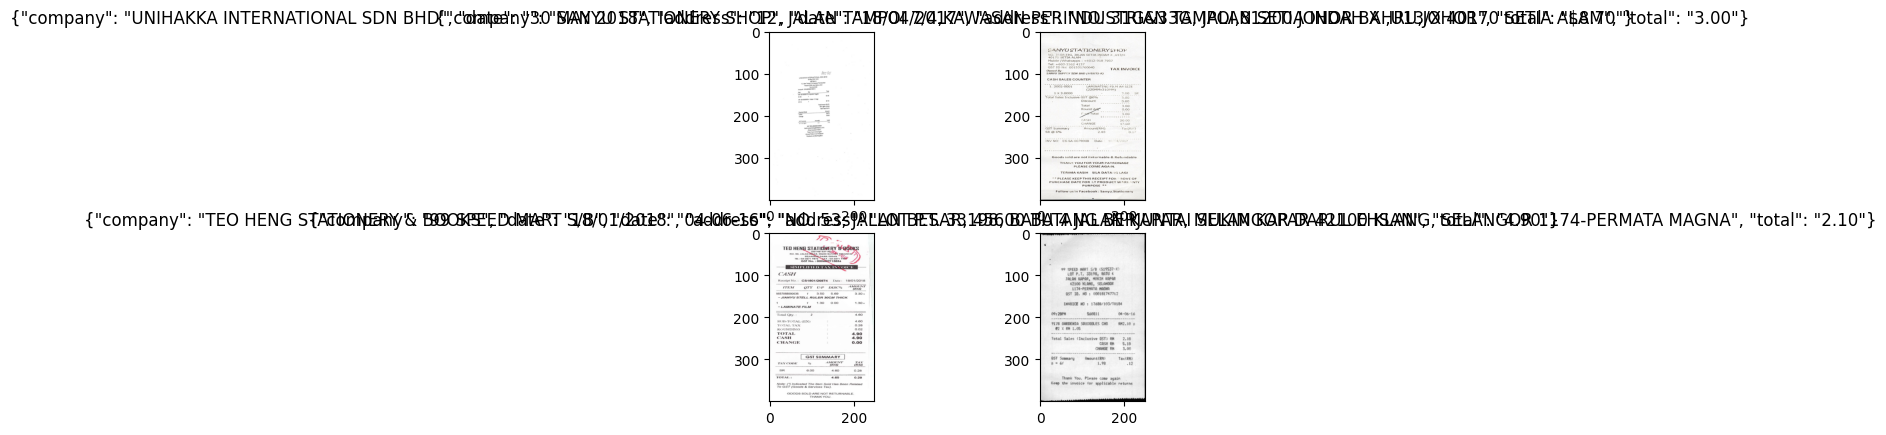

In [ ]:
import matplotlib.pyplot as plt
import random

fig,ax = plt.subplots(2,2)

for i in range(2):
  for j in range(2):
    rand_int = random.randint(0, len(dataset)-1)
    plt.grid(False)
    image = dataset[rand_int]['image'].resize((250,400))
    ocr = dataset[rand_int]['text']
    ax[i,j].imshow(image)
    ax[i,j].set_title(ocr)
plt.show()

**JSON2TOKEN by clovaAI**

In [ ]:
new_special_tokens = []
task_start_token = "<s>"
eos_token = "</s>"

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj

In [ ]:
# def preprocess_batch(batch):
#   processed_batch = []
#   for image, d_doc in zip(batch['image'], batch['text']):
#     text = task_start_token + json2token(d_doc) + eos_token
#     image = image.resize((720,960)).convert('RGB')
#     processed_batch.append({'image':image,'text':text})
#   return processed_batch

# preprocessed_data=[]
# batch_size=16
# for i in range(0, len(dataset), batch_size):
#   batch = dataset[i:i+batch_size]
#   processed = preprocess_batch(batch)
#   preprocessed_data.extend(processed)

In [ ]:
# def preprocess_batch(batch):
#   processed_batch = {"image": [], "text": []}
#   for image, d_doc in zip(batch['image'], batch['text']):
#     text = task_start_token + json2token(d_doc) + eos_token
#     image = image.resize((720,960)).convert('RGB')
#     processed_batch["image"].append(image)
#     processed_batch["text"].append(text)
#   return processed_batch

# processed_data = {"image": [], "text": []}
# batch_size=16
# for i in range(0, len(dataset), batch_size):
#   batch = dataset[i:i+batch_size]
#   processed = preprocess_batch(batch)
#   processed_data["image"].extend(processed["image"])
#   processed_data["text"].extend(processed["text"])

In [ ]:
from datasets import Dataset
# processed_dataset = Dataset.from_dict(processed_data)
# batch = processed_dataset[i:i+4]
# batch

In [ ]:
from transformers import T5Tokenizer
from transformers import DonutProcessor
# from transformers.tokenization_t5 import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')
donut_processor = DonutProcessor.from_pretrained('naver-clova-ix/donut-base', tokenizer_class=tokenizer)
donut_processor.tokenizer.add_special_tokens({"additional_special_tokens":new_special_tokens + [task_start_token] + [eos_token]})
donut_processor.image_processor.size = [720,960]
donut_processor.image_processor.do_align_long_axis = False

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# def preprocess_batch_tat(batch,processor=donut_processor, split="train", max_length=512, ignore_id=100):
#   processed_batch = {"pixel_values": [], "labels":[],"target_sequence": []}
#   for image, d_doc in zip(batch['image'], batch['text']):
#     try:
#       pixel_values = processor(image, random_padding=split =="train", return_tensors='pt').pixel_values.squeeze()
#     except Exception as e:
#       print(image)
#       print(f"Error: {e}")
#       return {}

#     input_ids = processor.tokenizer(d_doc, add_special_tokens=False, max_length=max_length,
#                                   padding="max_length", truncation=True, return_tensors='pt')["input_ids"].squeeze(0)
#     labels = input_ids.clone()
#     labels[labels==processor.tokenizer.pad_token_id] = ignore_id

#     processed_batch["pixel_values"].append(pixel_values)
#     processed_batch["labels"].append(labels)
#     processed_batch["target_sequence"].append(text)
#   return processed_batch

# batch_size=16
# final_dataset = {"pixel_values": [], "labels": [], "target_sequence": []}
# for i in range(0, len(processed_dataset), batch_size):
#   batch_tat = processed_dataset[i:i+batch_size]
#   processed_batch_tat = preprocess_batch_tat(batch_tat)

#   final_dataset["pixel_values"].extend(processed_batch_tat["pixel_values"])
#   final_dataset["labels"].extend(processed_batch_tat["labels"])
#   final_dataset["target_sequence"].extend(processed_batch_tat["target_sequence"])

In [ ]:
# data = Dataset.from_dict(final_dataset)

In [ ]:
# from datasets import Dataset
# final = Dataset.from_dict(final_dataset)
# batch_test = final[i:i+4]
# batch_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import zipfile
from datasets import load_dataset
zip_path = '/content/drive/MyDrive/new_data.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as z:
  z.extractall(extract_path)

In [ ]:
# %config NotebookApp.iopub_data_rate_limit=100000000
# %config NotebookApp.rate_limit_window = 10.0

In [ ]:
from datasets import load_from_disk
final_dataset = load_from_disk('/content/new_data')

In [ ]:
from sklearn.model_selection import train_test_split
sk_dataset = final_dataset.train_test_split(test_size=0.1)

**Fine tune and Evaluate DONUT**

**Set Model Configs**

In [ ]:
import torch
import transformers
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig, T5ForConditionalGeneration

model = VisionEncoderDecoderModel.from_pretrained('naver-clova-ix/donut-base')
new_embedding = model.decoder.resize_token_embeddings(len(donut_processor.tokenizer))
model.config.encoder.image_size = donut_processor.image_processor.size[::-1]
model.config.decoder.max_length = len(max(sk_dataset['train']['labels'], key=len))
model.config.pad_token_id = donut_processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = tokenizer.encode(['<s>'])[0]
# model.cpu()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
# device='cpu'
# model.to(device)

**Set training Arguments**

In [ ]:
# # !pip install transformers[torch]
# !pip install accelerate==0.21.0 -U

In [ ]:
import transformers
import accelerate
print(f"Transformers version: {transformers.__version__}\nAccelerate version: {accelerate.__version__}")

Transformers version: 4.31.0
Accelerate version: 0.21.0


In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
hf_repository_id = 'donut-base-sroie'

training_args = Seq2SeqTrainingArguments(
    output_dir = hf_repository_id,
    num_train_epochs = 3,
    learning_rate=2e-5,
    per_device_train_batch_size = 2,
    weight_decay = 0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy='no',
    save_strategy='epoch',
    predict_with_generate=True,

    report_to='tensorboard',
    push_to_hub = True,
    hub_strategy='every_save',
    hub_model_id = hf_repository_id,
    hub_token = HfFolder.get_token(),
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset = sk_dataset['train'],
    )

Cloning https://huggingface.co/nogi2k2/donut-base-sroie into local empty directory.


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,2.516800
200,0.088200
300,0.047100
400,0.036900
500,0.036800
600,0.042000
700,0.025600
800,0.025200


Several commits (2) will be pushed upstream.
Several commits (3) will be pushed upstream.


TrainOutput(global_step=846, training_loss=0.33475013503509776, metrics={'train_runtime': 3223.3654, 'train_samples_per_second': 0.524, 'train_steps_per_second': 0.262, 'total_flos': 2.970761500447949e+18, 'train_loss': 0.33475013503509776, 'epoch': 3.0})

In [ ]:
donut_processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

In [ ]:
# model.encoder.save_pretrained("./encoder")
# model.decoder.save_pretrained("./decoder")

**Model Evaluation and Testing**

In [ ]:
import re
import transformers
from transformers import VisionEncoderDecoderModel, DonutProcessor, TFVisionEncoderDecoderModel
import torch
import numpy as np
import random

processor = DonutProcessor.from_pretrained('nogi2k2/donut-base-sroie')
model = VisionEncoderDecoderModel.from_pretrained('nogi2k2/donut-base-sroie')
# _model = TFVisionEncoderDecoderModel.from_encoder_decoder_pretrained(
#     "./encoder", "./decoder", encoder_from_pt=True, decoder_from_pt=True
# )
# _model.config = model.config
device='cuda' if torch.cuda.is_available() else 'cpu'
test_sample =  sk_dataset['test'][random.randint(0,len(sk_dataset)-1)]

def prediction(sample, model=model,processor=processor):
  pixel_values=torch.tensor(test_sample['pixel_values']).unsqueeze(0)
  start_prompt='<s>'
  ip_ids = processor.tokenizer(start_prompt,add_special_tokens=False,return_tensors='pt').input_ids

  op = model.generate(
      pixel_values.to(device),
      decoder_input_ids=ip_ids,
      max_length = processor.config.max_position_embeddings,
      early_stopping=True,
      pad_token_id = processor.tokenizer.pad_token_id,
      eos_token_id = processor.tokenizer.eos_token_id,
      use_cache=True,
      num_beams=1,
      bad_words_ids = [[processor.tokenizer.unk_token_id]],
      return_dict_in_generate=True
  )

  prediction = processor.batch_decode(op.sequences)[0]
  prediciton = processor.token2json(prediction)
  target = processor.token2json(test_sample['target_sequence'])
  return prediction, target

prediction,target = prediction(test_sample)
print(f"Ground Truth: {target}\nPredicted: {prediction}")
processor.image_processor.to_pil_image(test_sample['pixel_values']).resize((350,600))

OSError: ignored

In [ ]:
from PIL import Image
device='cuda' if torch.cuda.is_available() else 'cpu'
def prediction_image(image, model=model, processor=processor):
  pixel_values = processor(image, return_tensors='pt').pixel_values
  prompt = '<s>'
  ip_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors='pt').input_ids

  op = model.generate(
      pixel_values.to(device),
      decoder_input_ids=ip_ids,
      max_length = processor.config.max_position_embeddings,
      early_stopping=True,
      pad_token_id = processor.tokenizer.pad_token_id,
      eos_token_id = processor.tokenizer.eos_token_id,
      use_cache=True,
      num_beams=1,
      bad_words_ids = [[processor.tokenizer.unk_token_id]],
      return_dict_in_generate=True
  )

  prediction = processor.batch_Decode(op.sequences)[0]
  prediction = processor.token2json(prediction)
  return prediction

path = ''
image = Image.open(path).resize((720,))